# Connect Four boardgame AI

In this notebook we construct the boardgame "Connect Four" as a Python class and implement Monte Carlo Tree Simulation (MCTS) to learn an AI opponent.

In [1]:
#Import relevant packages

import numpy as np
import pandas as pd
import random
import copy
import math
import matplotlib.pyplot as plt
from matplotlib import colors

from IPython.display import clear_output

## 1. The `ConnectFour` class

The following cell implements the `ConnectFour` class; each `ConnectFour` object represents a game of Connect Four.  An object's primary attributes are: a board state `self.board_state`, the turn `self.turn` of the game, the status of the game `self.is_won`, the legal moves the active player can play `self.legal_moves`, and the location of the previous chip's placement `self.last_move`.

To play a chip for the active player in column `col`, one issues the `self.play_chip(col)` function.

In [2]:
class ConnectFour:
    win_length = 4
    num_rows = 6
    num_cols = 7

    #Each ConnectFour object is a board_state, which is an array
    #of 0's (empty squares), 1's (red chips) and -1's (black chips).
    #The red chips are played on even turns (initial turn is turn 0), black chips on odd turns.
    def __init__(self):
        #On initialization, the board_state is empty, the turn is 0, the game is not won, all moves are legal, and the last move is nonsense.
        self.board_state = np.zeros((self.num_rows,self.num_cols), dtype=int)
        self.turn = 0
        self.is_won = False
        self.is_over = False
        self.legal_moves = np.arange(7)
        self.last_move = (-1,-1)
        
    def reset(self):
        #self.reset resets all the game parameters to their initial state.
        self.board_state = np.zeros((self.num_rows,self.num_cols), dtype=int)
        self.turn = 0
        self.is_won = False
        self.is_over = False
        self.legal_moves = np.arange(7)
        self.last_move = (-1,-1)

    def play_chip(self, column):
        #First check if the game is over:
        if self.is_won == True:
            #print('The game is over; %s has won.' % self.winner)
            return
        elif (self.is_won == False and self.legal_moves.size == 0):
            #print('The game has ended in a draw.')
            return
        else:
            #Player whose turn it is places a chip in column
            #Determine whose turn it is:
            if self.turn % 2 == 0:
                chip = 1
            else:
                chip = -1

            #If suggested move is legal, play the chip in column and go to next turn.
            if column in self.legal_moves:
                self.last_move = np.amax(np.where(self.board_state[:,column] == 0)),column
                self.board_state[self.last_move] = chip
                self.turn += 1
            else:
                print('Column is full; please suggest another move.')


            #Check to see if the game has been won:
            self.check_win()
            
            #Redetermine the legal moves in the board_state:
            self.legal_moves = np.where(self.board_state[0]==0)[0]
            
            if self.is_won == True:
                #print('The game is over; %s wins!' % self.winner)
                self.is_over = True
            elif (self.is_won == False and self.legal_moves.size == 0):
                #print('The game has ended in a draw.')
                self.is_over = True

    def check_win(self):
        #Checks for a winning position for both players relative to self.last_move:
        y,x = self.last_move

        #Check for column wins containing self.last_move (there can be only one):
        if (y <= self.num_rows - self.win_length):
            sum_temp = 0
            for k in range(0,self.win_length):
                sum_temp += self.board_state[y+k][x]
            if sum_temp == self.win_length:
                self.winner = 'Player 1'
                self.is_won = True
                return
            elif sum_temp == -self.win_length:
                self.winner = 'Player 2'
                self.is_won = True
                return

        #Check for row wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols - self.win_length and x-i >= 0):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

        #Check for diagonal \\ wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols-self.win_length and x-i >=0 and y-i <= self.num_rows - self.win_length and y-i >= 0):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y-i+k][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

        #Check for diagonal // wins containing self.last_move:
        for i in range(0,self.win_length):
            if (x-i <= self.num_cols-self.win_length and x-i >= 0 and y+i > self.num_rows - self.win_length and y+i <= 5):
                sum_temp = 0
                for k in range(0,self.win_length):
                    sum_temp += self.board_state[y+i-k][x-i+k]
                if sum_temp == self.win_length:
                    self.winner = 'Player 1'
                    self.is_won = True
                    return
                elif sum_temp == -self.win_length:
                    self.winner = 'Player 2'
                    self.is_won = True
                    return

We initialize a sample game and play a few moves below:

In [3]:
game = ConnectFour()

game.play_chip(0)
game.play_chip(1)
game.play_chip(0)

game.board_state

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  0,  0,  0,  0,  0]])

## 2. A user-friendly implementation

Below we create a simple user-friendly implementation, where Python continually requests inputs from players.

First, we introduce simple function to display the game's board state:

In [4]:
# create discrete colormap
cmap = colors.ListedColormap(['b', 'w', 'r'])
bounds = [-1,0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def plot_matrix(rm, title='Connect Four'):
    fig, ax = plt.subplots()
    ax.imshow(rm, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(-.5, 7, 1));
    ax.set_yticks(np.arange(-.5, 6, 1));
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    plt.show()

Running the cell below will initialize a game of Connect Four and prompt each player to enter their respective moves.

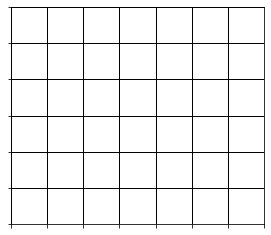

Player 1, it is your turn.



KeyboardInterrupt: Interrupted by user

In [5]:
game = ConnectFour()

while(game.is_over == False):
    plot_matrix(game.board_state)
    
    current_player = str((game.turn % 2)+1)
    print('Player %s, it is your turn.\n' % current_player)
    next_move = int(input('Enter a column (1-7) to play a move:'))-1
    
    while (next_move not in game.legal_moves):
        print('Please enter a valid command.')
        next_move = int(input('Enter a column (1-7) to play a move:'))-1
        
    game.play_chip(next_move)
    clear_output()

if (game.is_won == True):
    print('The game is over; %s wins!' % game.winner)
elif (game.is_won == False and game.legal_moves.size == 0):
    print('The game has ended in a draw.')

print('The final position:\n')
plot_matrix(game.board_state)

game.reset()

## 3. MCTS:

In [6]:
EXP_PARAMETER = math.sqrt(2)

In [7]:
#  Here is my implementation of the game_node class
# a game_node is meant to represent a node in our monte carlo tree
class game_node:
    def __init__(self, game, parent,prior_move):
        #Who's your daddy?  A pointer to the parent.  Should be None if the root.
        self.parent = parent
        
        #How many times have you been here?  Did you win?  Currently not used.
        self.num_visits = 0
        self.num_wins = 0
        #We store the current board state.  Ultimately unnecessary but easy for now
        self.game = game
        #What are the legal moves and how many
        self.legal_moves = game.legal_moves
        self.num_legal_moves = len(self.legal_moves)
        
        # We store the move made to arrive to the current game node.  Useful for backpropagation.  Possibly not needed but not harmful
        self.prior_move = prior_move
        
        # the statistics about children are scores so that we can pick which child to visit when we are here
        #child_scores scored as a pandas dataframe with 3 columns: num_visits, num_wins, score
        #score is only updated once all children have been visited
        #of note:  this is likely the most wasteful part, especially since if we replace it with a numpy array, we can
        #probably use Numba to speed up our code tremendously
        self.child_scores =pd.DataFrame(dtype = 'float',index = game.legal_moves, columns = ['num_visits','num_wins','score']).fillna(0)
        
        # children is a dictionary with keys given by legal_moves and outputs are pointers to the appropriate children
        #it is updated each time a new child is visited
        self.children = {}
        #Active player isn't strictly necessary, but so easy to store.
        self.active_player = (-1)**(game.turn)

        # This should be edited to make it so that if a parent has a winning move, we stop doing any thinking there.  why bother?
        # For now it stays, but in future updates it should be gone.
        if game.is_won:
            self.all_children_visited = True
        else:
            self.all_children_visited = False

        
    #pick_and_play_move picks the best new move as per score if all children visited
    # if there remains an unvisited child, then one is picked at random
    # The output is [pointer_to_child_node, Boolean_value]
    # the boolean is set to true if the child is a newly created node (and thus we should play a random game)

    def pick_and_play_move(self):
        if self.game.is_won:
            print('Make a better error code')
            return(None)
        if self.all_children_visited:
            next_move = self.child_scores.score.idxmax()
            return([self.children[next_move],  False])
        else:
            df = self.child_scores
            moves_left = df[df.num_visits ==0].index.values
            choice = random.randint(0,len(moves_left)-1)
            return([self.play_new_move(moves_left[choice]), True])

    
    def play_random_move(self):
        n = len(self.legal_moves)
        return(self.play_new_move(self.legal_moves[random.randint(0,n-1)]))

    # play_new_move creates a child node using the move legal_move updates our internal data and then returns a pointer to the child    
    def play_new_move(self, legal_move):
        child_game = copy.deepcopy(self.game)
        child_game.play_chip(legal_move)
        child_node = game_node(child_game, self,legal_move)
        self.children[legal_move] = child_node
        return(child_node)
        

    # backpropogate is probably misspelled.  It accepts as input the player who won the pertinent leaf (1 or -1)
    # the top_node to which we wish to backpropogate (no sense going back to the root if we are on move 20)
    # and the last move_played (so that the parent can easily update its internal statistics)
    # it updates the current node's child_scores and then recursively calls itself on the parent.  the return is the parent
    
    def backpropogate(self, winner, top_node = None, move_played = None):
        self.num_visits = self.num_visits+1
        score = ((-1)**(self.game.turn)*winner+1)/2
        self.update_child_scores(score = score, move_played = move_played)
        if (top_node == self) or (self.parent==None):
            return(self)
        else:
            return(self.parent.backpropogate( winner = winner, top_node = top_node, move_played = self.prior_move))
    
    # update_child_scores takes as input the score (-1 or 1 if one of them wins, 0 if it's a draw) and the move that
    #was played in this position
    # it then updates our child_scores dataframe
    def update_child_scores(self, score, move_played):

        df = self.child_scores
        df.loc[move_played,'num_visits'] = df.loc[move_played,'num_visits']+1
        df.loc[move_played,'num_wins'] = df.loc[move_played,'num_wins']+score
        if self.all_children_visited:
            df['score'] = df.num_wins/df.num_visits+EXP_PARAMETER*np.sqrt(np.log(self.num_visits)/df.num_visits)
        elif not (df.num_visits==0).sum():
            self.all_children_visited=True

                

    

In [8]:
##########  Other Scripts
# These are functions we call from outside game nodes.  Eventually it might make sense to have
# a game_tree class that manages them
#play_random_game(node) plays a random game starting at the given node and returns the final position.
def play_random_game(node):
    current_node = node
    while not current_node.game.is_won:
        if current_node.num_legal_moves ==0:
            return(current_node)
        else:
            current_node = current_node.play_random_move()
    return(current_node)

#simulate_round starts at the input node and explores until it sees a new vertex created
#then it plays a random game and backpropogates the score
def simulate_round(node):
    current_node = node
    flag = False
    while not flag | current_node.game.is_won:
        [current_node,flag] = current_node.pick_and_play_move()
    if current_node.game.is_won:
        outcome = current_node
    else:
        outcome = play_random_game(current_node)
    if outcome.game.is_won:
        winner = (-1)**(outcome.game.turn+1)
    else:
        winner = 0
        #print('good game! it\'s a draw!')
    outcome.parent.backpropogate(winner = winner, top_node = node, move_played = outcome.prior_move)
        

In [9]:
root = game_node(game, None, None)

In [10]:
for i in range(5000):
    current_node = root
    flag = False
    while not flag | current_node.game.is_won:
        [current_node,flag] = current_node.pick_and_play_move()
    if current_node.game.is_won:
        outcome = current_node
    else:
#         new_node = current_node.pick_and_play_move()[0]
        outcome = play_random_game(current_node)
    if outcome.game.is_won:
        winner = (-1)**(outcome.game.turn+1)
    else:
        winner = 0
        print('good game! it\'s a draw!')
    outcome.parent.backpropogate(winner = winner, top_node = root, move_played = outcome.prior_move)

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game has ended in a draw.
good game! it's a draw!
The game is over; Play

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game h

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game i

The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 2 wins!
The game is over; Player 1 wins!
The game is over; Player 1 wins!
The game i

## 4. Let's play a game.

Let's use the MCTS techniques above to develop a CPU opponent, and let the user play against it.  At first we will insist the user be Player 2.

The game is over; Player 1 wins!
The final position:



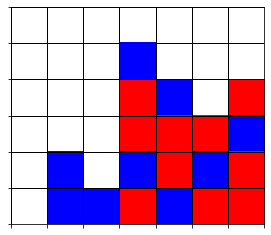

In [10]:
game = ConnectFour()
root = game_node(game,None,None)
current_node = root

while(game.is_over == False):
    #Print the current board state
    plot_matrix(game.board_state)
    
    current_player = str((game.turn % 2)+1)
    if current_player == '1':
        print('Thinking...')
        for i in range(500):
            simulate_round(current_node)
        df = current_node.child_scores.copy()
        df['win_rates'] = df.num_wins/df.num_visits
        
        best_moves = list(df.sort_values(by = ['win_rates'], ascending = False).index)
        i = 0
        while best_moves[i] not in game.legal_moves:
            i += 1
        cpu_move = best_moves[i]
        
        game.play_chip(cpu_move)
        current_node = current_node.children[cpu_move]
        
    else:
        next_move = int(input('Enter a column (1-7) to play a move:'))-1
        while (next_move not in game.legal_moves):
            print('Please enter a valid command.')
            next_move = int(input('Enter a column (1-7) to play a move:'))-1
        game.play_chip(next_move)
        
        current_node = current_node.children[next_move]
        
        
    clear_output()
    

if (game.is_won == True):
    print('The game is over; %s wins!' % game.winner)
elif (game.is_won == False and game.legal_moves.size == 0):
    print('The game has ended in a draw.')

print('The final position:\n')
plot_matrix(game.board_state)

game.reset()

In [76]:
df

,num_visits,num_wins,score,win_rates
0,117.0,91.5,1.098493,0.782051
1,156.0,128.5,1.097765,0.823718
6,77.0,55.5,1.110849,0.720779
